# Optimizing Direct Marketing Campaign Using Machine Learning
This analyis goes through my model creatation for a direct Marketing campaign. The data is from marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).<br>

Outline<br>
1. Assumptions
2. Data Exploration and Motivations For Imbalanced Classification Techniques
3. Weighted Model Training
4. Downsampling Majority Class Model Training
5. Model Parameter Refinement
6. Final Model Evaluation
7. Conclusion

- The data can be found at the UCI Machine Learning repository. <br>
https://archive.ics.uci.edu/dataset/222/bank+marketing

## 1. Assumptions
For this direct marketing campaign, I’m assuming that the primary objective is to maximize the number of correctly predicted "yes" responses—i.e., identifying as many potential positive responders as possible.<br>
<br>
While other evaluation metrics like accuracy, F1-score, and ROC-AUC are also important, the optimal metric depends on the specific business context.<br>
<br>
In this case, the most appropriate metric to optimize is recall for the "yes" class, which measures the percentage of actual positive responders that are correctly identified by the model.<br>

## 2. Data Exploration

In [ ]:
#Import Dependencies
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import pandas as pd

In [27]:
#Load Data
df = pd.read_csv("bank-additional-full.csv",sep = ";")

In [ ]:
#drop protected data from the CFPB
#https://wayback.archive-it.org/23481/20250327014847/https://www.consumerfinance.gov/compliance/circulars/circular-2023-03-adverse-action-notification-requirements-and-the-proper-use-of-the-cfpbs-sample-forms-provided-in-regulation-b/
protected_features = ['age','marital']
df = df.drop(protected_features, axis=1)


In [29]:
df.head()

,job,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,housemaid,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,services,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,services,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,admin.,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,services,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [ ]:
# Define features, X, and target, y
X = df[['job', 'education', 'default', 'housing', 'loan', 'contact', 'month',
        'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome',
        'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m',
        'nr.employed']]
y = df['y'].map({'yes': 1, 'no': 0})
# Define categorical and numeric features
categorical_features = ['job', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
numeric_features = ['duration', 'campaign', 'pdays', 'previous', 'emp.var.rate']


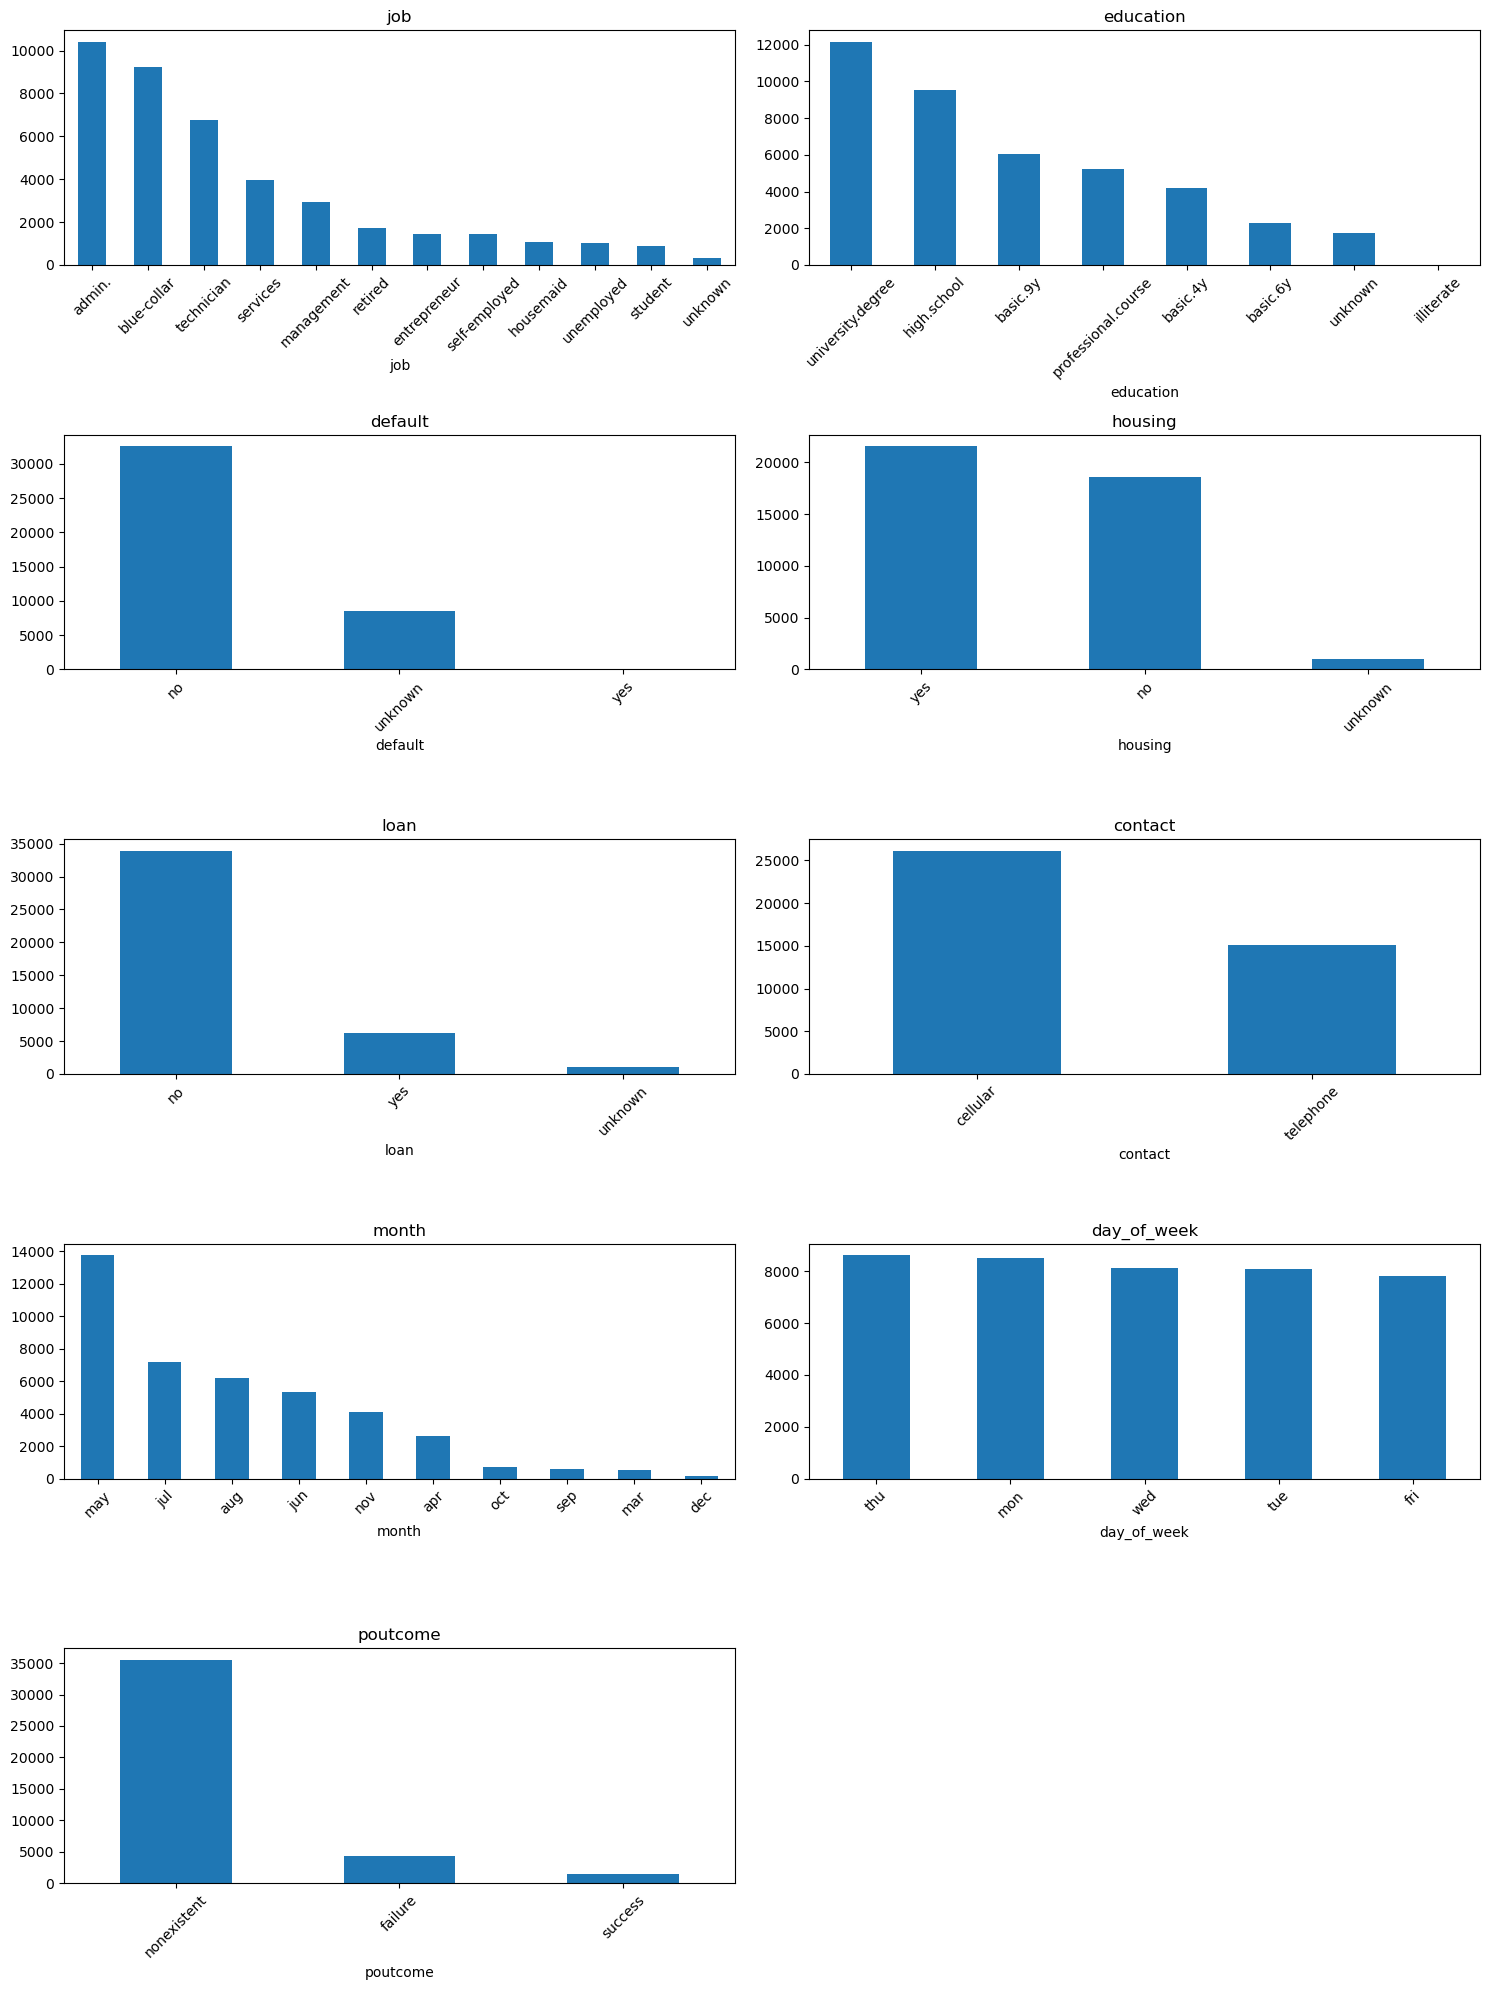

In [ ]:
#Plot the categorical features.
def plot_categorical_counts(df, categorical_cols, rows, cols):
   fig, axes = plt.subplots(rows, cols, figsize=(15, 20))
   axes = axes.flatten()

   for i, col in enumerate(categorical_cols):
      df[col].value_counts().plot(kind='bar', ax=axes[i])
      axes[i].set_title(col)
      axes[i].tick_params(axis='x', rotation=45)

   for j in range(i + 1, len(axes)):
      fig.delaxes(axes[j])

   plt.tight_layout()
   plt.show()
           
plot_categorical_counts(X,categorical_features,5,2)

[]

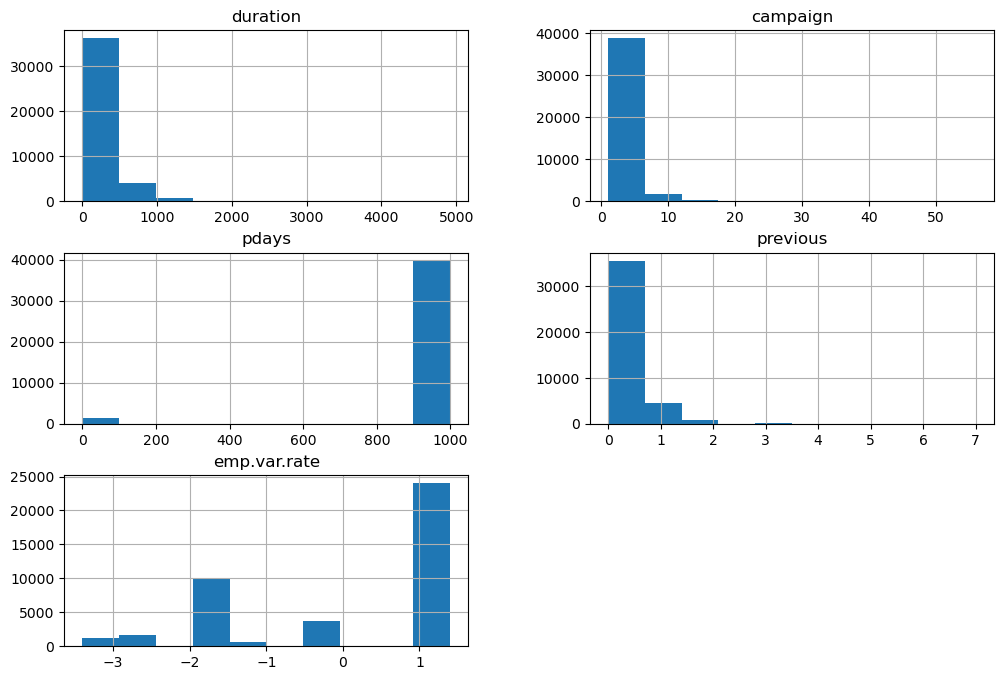

In [31]:
#now to the numeric features
df[numeric_features].hist(figsize=(12, 8))
plt.plot()


Text(0.5, 1.0, 'Distribution of Target Variable')

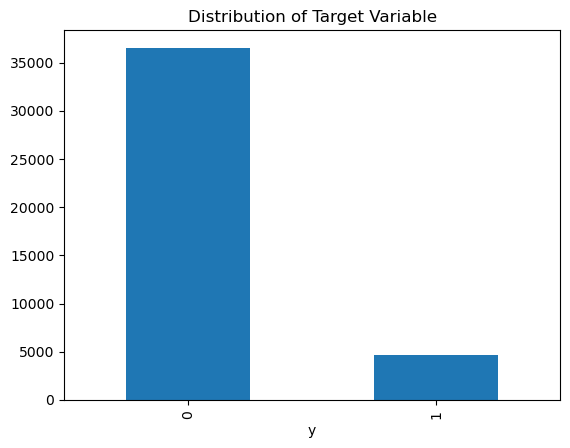

In [10]:
#Finally the target variable
counts_y = y.value_counts()
counts_y.plot(kind='bar')
plt.title("Distribution of Target Variable")

### Imbalanced Data
The dataset is highly imbalanced, with significantly more non-responders ("0") than responders ("1"). If this imbalance is not addressed, a model could simply predict "0" for every observation and still achieve around 90% accuracy—while completely failing to identify actual responders.<br>
<br>
There are two common strategies to address this issue:<br>

1. Undersampling the majority class (non-responders) to balance it with the minority class (responders).

2. Adjusting the reward structure so that correctly predicting responders has a greater influence on model performance.
<br>

In this analysis, I’ll begin by using the second approach—modifying the model to place more weight on correctly identifying responders.

## 3. Weighted Model Training

In [ ]:

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)



# Define preprocessing pipeline
# You could try and make some of your own transformations to give the model some sense of order to some of the categorical features such as education but one-hot-encoding is fast
# For the numeric values you can try other scaling techniques like taking the log for highly distributed data but I will use the standard scaler for ease of use
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features), 
        ('num', StandardScaler(), numeric_features)
    ]
)
# Calculate class imbalance ratio
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / pos
print(f"scale_pos_weight = {scale_pos_weight:.2f}")

# Define classifiers making sure to set the class_weight to balance or calculating the scale position weight for XGBoost.
models = {
   "Dummy Classifier": DummyClassifier(strategy='stratified'), #The dummy classifier randomly choose 0 or 1 at the same rate as the training set frequency, this is an easy way to tell your classifier is working, especially for imbalanced data sets.
   "Logistic Regression": LogisticRegression(max_iter=500,class_weight='balanced'),
   "Random Forest": RandomForestClassifier(class_weight='balanced'),
   #"Gradient Boosting": HistGradientBoostingClassifier(class_weight='balanced'), recieve an error data was too sparse, which means the one-hot-encoding won't work for this model. I'll skip it for this analysis
   "SVM": SVC(probability=True,class_weight='balanced'),
   "KNN": KNeighborsClassifier(weights='distance'),
   "XGBoost": XGBClassifier(eval_metric='logloss',scale_pos_weight = scale_pos_weight)
}

# Evaluation metrics
scoring = ['accuracy', 'f1', 'roc_auc','recall']



# Cross-validation on training data
results = {}
for name, model in models.items():
    clf = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
    scores = cross_validate(clf, X_train, y_train, cv=3, scoring=scoring,verbose=4)
    results[name] = {
        'Accuracy (CV)': scores['test_accuracy'].mean(),
        'F1 Score (CV)': scores['test_f1'].mean(),
        'ROC AUC (CV)': scores['test_roc_auc'].mean(),
        'Recall (CV)': scores['test_recall'].mean()
    }


scale_pos_weight = 7.88
[CV] END  accuracy: (test=0.798) f1: (test=0.114) recall: (test=0.116) roc_auc: (test=0.503) total time=   0.2s
[CV] END  accuracy: (test=0.800) f1: (test=0.118) recall: (test=0.119) roc_auc: (test=0.500) total time=   0.1s
[CV] END  accuracy: (test=0.804) f1: (test=0.115) recall: (test=0.113) roc_auc: (test=0.503) total time=   0.2s
[CV] END  accuracy: (test=0.863) f1: (test=0.591) recall: (test=0.874) roc_auc: (test=0.933) total time=   0.4s
[CV] END  accuracy: (test=0.857) f1: (test=0.577) recall: (test=0.865) roc_auc: (test=0.930) total time=   0.2s
[CV] END  accuracy: (test=0.855) f1: (test=0.578) recall: (test=0.884) roc_auc: (test=0.935) total time=   0.2s
[CV] END  accuracy: (test=0.907) f1: (test=0.484) recall: (test=0.386) roc_auc: (test=0.932) total time=  16.3s
[CV] END  accuracy: (test=0.904) f1: (test=0.463) recall: (test=0.367) roc_auc: (test=0.925) total time=  14.5s
[CV] END  accuracy: (test=0.903) f1: (test=0.475) recall: (test=0.390) roc_auc: 

In [ ]:
# Show results
results_df = pd.DataFrame(results).T.sort_values(by='Recall (CV)', ascending=False)
print(results_df)


                     Accuracy (CV)  F1 Score (CV)  ROC AUC (CV)  Recall (CV)
SVM                       0.843854       0.567311      0.930129     0.908406
Logistic Regression       0.858361       0.581759      0.932752     0.874192
XGBoost                   0.874749       0.595873      0.933048     0.819234
KNN                       0.896328       0.460689      0.848966     0.393048
Random Forest             0.904704       0.473997      0.928671     0.381195
Dummy Classifier          0.800516       0.115700      0.501963     0.115841


## 4. Downsampling Method for Imbalanced Model Training
The weighted training approach produced promising results in handling the class imbalance. Now, let's evaluate an alternative method—downsampling the majority class (non-responders)—to see how it compares in terms of model performance.

In [ ]:
from sklearn.utils import resample
df2 = df.copy()

X_u = df2[['job', 'education', 'default', 'housing', 'loan', 'contact', 'month',
        'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome',
        'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m',
        'nr.employed']]
y_u = df2['y'].map({'yes': 1, 'no': 0})


#split the test data before downsampling this is very important

X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(
    X_u, y_u, test_size=0.2, random_state=42, stratify=y_u
)

#reconnect training df's for downsampling

df_rejoined = X_train_u.assign(y = y_train_u)


# Separate majority and minority classes


df_majority = df_rejoined[df_rejoined['y'] == 0]# Majority class
df_minority = df_rejoined[df_rejoined['y'] == 1]  # Minority class

# Undersample majority class to match the minority count
df_majority_downsampled = resample(df_majority, 
                                   replace=False,  # Sample without replacement
                                   n_samples=len(df_minority),  # Match minority count
                                   random_state=42)

# Combine back into a new undersampled dataset
df_undersampled = pd.concat([df_majority_downsampled, df_minority])


# Redefine X and y based on the undersampled dataset
# Make sure to use these variables since X_train_u and y_train_u are not undersampled yet
X_train_undersampled = df_undersampled.drop(columns=['y'])
y_train_undersampled = df_undersampled['y']



In [ ]:

categorical_features = ['job', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
numeric_features = ['duration', 'campaign', 'pdays', 'previous', 'emp.var.rate']


#now we don't need to balance the training outputs
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features), 
        ('num', StandardScaler(), numeric_features)
    ]
)

# Define classifiers
models_u = {
   "Dummy Classifier": DummyClassifier(), #The dummy classifier will always pick 0 or 1 at random, this is an easy way to tell your classifier is working, especially for imbalanced data sets.
   "Logistic Regression": LogisticRegression(max_iter=500),
   "Random Forest": RandomForestClassifier(),
   #"Gradient Boosting": HistGradientBoostingClassifier(class_weight='balanced'), recieve an error data was too sparse, which means the one-hot-encoding won't work for this model. I'll skip it for this analysis
   "SVM": SVC(probability=True),
   "KNN": KNeighborsClassifier(),
   "XGBoost": XGBClassifier(eval_metric='logloss')
}

# Evaluation metrics
scoring = ['accuracy', 'f1', 'roc_auc','recall']

# Cross-validation on training data
results2 = {}
for name, model in models_u.items():
    clf = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
    scores = cross_validate(clf, X_train_undersampled, y_train_undersampled, cv=3, scoring=scoring,verbose=4)
    results2[name] = {
        'Accuracy (CV)': scores['test_accuracy'].mean(),
        'F1 Score (CV)': scores['test_f1'].mean(),
        'ROC AUC (CV)': scores['test_roc_auc'].mean(),
        'Recall (CV)': scores['test_recall'].mean()
    }

[CV] END  accuracy: (test=0.500) f1: (test=0.666) recall: (test=1.000) roc_auc: (test=0.500) total time=   0.0s
[CV] END  accuracy: (test=0.500) f1: (test=0.000) recall: (test=0.000) roc_auc: (test=0.500) total time=   0.0s
[CV] END  accuracy: (test=0.500) f1: (test=0.000) recall: (test=0.000) roc_auc: (test=0.500) total time=   0.0s
[CV] END  accuracy: (test=0.868) f1: (test=0.869) recall: (test=0.873) roc_auc: (test=0.932) total time=   0.1s
[CV] END  accuracy: (test=0.849) f1: (test=0.852) recall: (test=0.865) roc_auc: (test=0.918) total time=   0.1s
[CV] END  accuracy: (test=0.868) f1: (test=0.869) recall: (test=0.878) roc_auc: (test=0.940) total time=   0.1s
[CV] END  accuracy: (test=0.872) f1: (test=0.876) recall: (test=0.901) roc_auc: (test=0.934) total time=   3.5s
[CV] END  accuracy: (test=0.864) f1: (test=0.871) recall: (test=0.914) roc_auc: (test=0.919) total time=   3.1s
[CV] END  accuracy: (test=0.873) f1: (test=0.878) recall: (test=0.914) roc_auc: (test=0.935) total time=

In [19]:
# Show results
results_df = pd.DataFrame(results2).T.sort_values(by='Recall (CV)', ascending=False)
print(results_df)

                     Accuracy (CV)  F1 Score (CV)  ROC AUC (CV)  Recall (CV)
SVM                       0.868266       0.874545      0.928017     0.918375
Random Forest             0.869882       0.874886      0.929067     0.909751
XGBoost                   0.867458       0.872097      0.929281     0.903826
Logistic Regression       0.861666       0.863118      0.930044     0.872039
KNN                       0.827183       0.826642      0.891339     0.823816
Dummy Classifier          0.499865       0.222162      0.500000     0.333333


## 5. Model Parameter Refinement
Both class imbalance strategies performed well, with downsampling yielding slightly better results in this case.<br>

Next, we'll evaluate how the models perform when trained on the entire dataset, rather than just on subsets created during cross-validation. This will help us understand how the models generalize when exposed to all available data.<br>

In [20]:
# Dictionary to store trained models
trained_models = {}

for name, model in models_u.items():
    clf = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
    clf.fit(X_train_undersampled, y_train_undersampled)  # Train on full training set
    trained_models[name] = clf

In [21]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score

# Dictionary to store test evaluation results
test_results = {}

for name, model in trained_models.items():
    y_pred = model.predict(X_test_u)
    y_prob = model.predict_proba(X_test_u)[:, 1] if hasattr(model, "predict_proba") else None  # For ROC AUC

    test_results[name] = {
        'Accuracy': accuracy_score(y_test_u, y_pred),
        'F1 Score': f1_score(y_test_u, y_pred),
        'ROC AUC': roc_auc_score(y_test_u, y_prob) if y_prob is not None else None,
        'Recall': recall_score(y_test_u, y_pred)
    }

# Convert results to a DataFrame for better visualization
test_results_df = pd.DataFrame(test_results).T.sort_values(by='Recall', ascending=False)
print(test_results_df)

                     Accuracy  F1 Score   ROC AUC    Recall
SVM                  0.837218  0.567559  0.941440  0.948276
Random Forest        0.852270  0.587318  0.943353  0.933190
XGBoost              0.850328  0.580184  0.941048  0.918103
Logistic Regression  0.862588  0.597726  0.941523  0.906250
KNN                  0.844622  0.557093  0.908619  0.867457
Dummy Classifier     0.887351  0.000000  0.500000  0.000000


### Model Evaluation
- Across all models, Random Forest and Logistic Regression delivered the best balance of performance metrics.
- Random Forest achieved the highest recall (93.3%) after SVM and maintained a strong F1 score and ROC AUC, making it a strong choice for prioritizing responder identification.
- Logistic Regression had the highest accuracy (86.3%) and F1 score, with competitive recall and ROC AUC—showing strong generalization and balanced performance.
- SVM delivered the highest recall (94.8%) but with a slightly lower F1 score, indicating more false positives.
- XGBoost performed comparably but slightly under the top models.
- KNN showed reasonable accuracy but lagged in recall and ROC AUC.
- The Dummy Classifier confirms the challenge of the class imbalance, achieving high accuracy by predicting only the majority class, with zero ability to identify responders.

To continue with our initial assumption let's maximize the recall by refining the SVM mode's parameters.

## 6. Final Model Evaluation

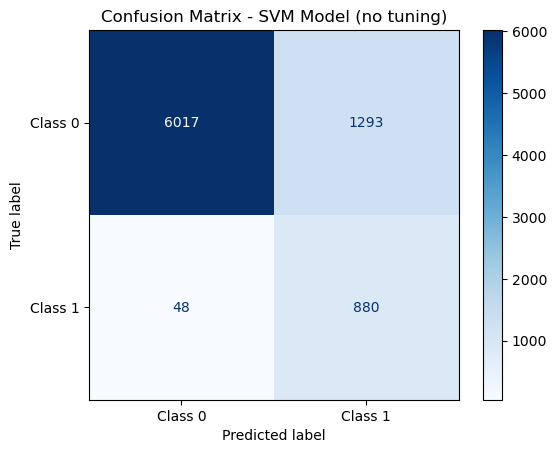

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#First let's look at the SVM model performance with no tuning.

# Generate predictions from the trained SVM model 
y_pred = trained_models["SVM"].predict(X_test_u)

# Compute confusion matrix
cm = confusion_matrix(y_test_u, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - SVM Model (no tuning)")
plt.show()


In [23]:
from sklearn.model_selection import RandomizedSearchCV


# Define the SVM model
svm = SVC(probability=True)

# Define the parameter grid
param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf', 'poly'],
    'classifier__gamma': ['scale', 0.1, 1],
    'classifier__degree': [2, 3]  # Only relevant for 'poly' kernel
}

# Create the pipeline with preprocessing and SVM classifier
svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', svm)
])

# Perform Randomized Search CV
random_search = RandomizedSearchCV(svm_pipeline, param_grid, cv=5, scoring='recall', n_iter=10, verbose=4, n_jobs=-1)
random_search.fit(X_train_undersampled, y_train_undersampled)

# Best parameters
print(f"Best parameters: {random_search.best_params_}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'classifier__kernel': 'rbf', 'classifier__gamma': 1, 'classifier__degree': 3, 'classifier__C': 1}


### Training the best SVM
Finally, we’ll train the optimized SVM model on the entire training dataset and evaluate its performance on the test set. We’ll also visualize the results using a confusion matrix to better understand the model’s classification behavior.

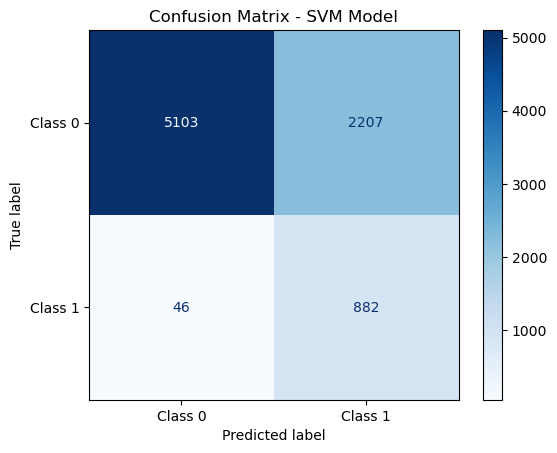

In [24]:
best_svm_pipeline = random_search.best_estimator_
best_svm_pipeline.fit(X_train_undersampled,y_train_undersampled)
y_pred = best_svm_pipeline.predict(X_test_u)

# Compute confusion matrix
cm = confusion_matrix(y_test_u, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - SVM Model")
plt.show()


### SVM Parameter Tuning Conclusion
In this case, parameter tuning for the SVM model resulted in only marginal improvements in performance. To explore potential gains, we'll now turn to XGBoost, a model well-regarded for its flexibility and tunability. Let's see if fine-tuning an XGBoost model yields better results.

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best XGBoost Model Parameters: {'classifier__subsample': 0.8, 'classifier__n_estimators': 25, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.01, 'classifier__gamma': 0.1, 'classifier__colsample_bytree': 1}
Best XGBoost model trained on the full dataset!


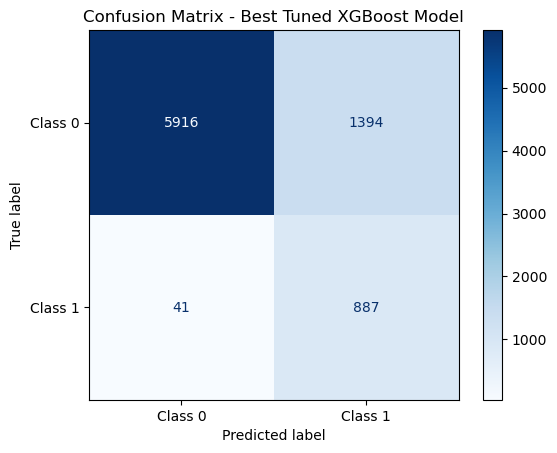

In [25]:


# Define the XGBoost classifier
xgb = XGBClassifier(eval_metric='logloss')

# Define hyperparameter search space
param_grid = {
    'classifier__n_estimators': [10, 25, 50, 100, 200, 300],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__gamma': [0, 0.1, 0.2, 0.3],
    'classifier__subsample': [0.8, 1],
    'classifier__colsample_bytree': [0.6, 0.8, 1],
}

# Define pipeline with preprocessing + XGBoost
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb)
])

random_search_xgb = RandomizedSearchCV(
    xgb_pipeline, param_grid, cv=5, scoring='recall', 
    n_iter=15, verbose=2, n_jobs=-1, random_state=42
)

random_search_xgb.fit(X_train_undersampled, y_train_undersampled)

# Best parameters from tuning
print(f"Best XGBoost Model Parameters: {random_search_xgb.best_params_}")
# Get the best trained model
best_xgb_pipeline = random_search_xgb.best_estimator_

# Retrain on full dataset
best_xgb_pipeline.fit(X_train_undersampled, y_train_undersampled)
print("Best XGBoost model trained on the full dataset!")

y_pred_best_xgb = best_xgb_pipeline.predict(X_test_u)

# Compute confusion matrix
cm_xgb = confusion_matrix(y_test_u, y_pred_best_xgb)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=["Class 0", "Class 1"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Best Tuned XGBoost Model")
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score

# Get predictions
y_pred_best_svm = best_svm_pipeline.predict(X_test_u)
y_pred_best_xgb = best_xgb_pipeline.predict(X_test_u)
y_pred_trained_svm = trained_models["SVM"].predict(X_test_u)

# Get probabilities for ROC AUC (if applicable)
y_prob_best_svm = best_svm_pipeline.predict_proba(X_test_u)[:, 1]
y_prob_best_xgb = best_xgb_pipeline.predict_proba(X_test_u)[:, 1]
y_prob_trained_svm = trained_models["SVM"].predict_proba(X_test_u)[:, 1]

# Define function for evaluation
def evaluate_model(name, y_true, y_pred, y_prob):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "ROC AUC": roc_auc_score(y_true, y_prob)
    }

# Evaluate models
results_comparison = {
    "Best Tuned SVM": evaluate_model("Best Tuned SVM", y_test_u, y_pred_best_svm, y_prob_best_svm),
    "Best Tuned XGBoost": evaluate_model("Best Tuned XGBoost", y_test_u, y_pred_best_xgb, y_prob_best_xgb),
    "Original Trained SVM": evaluate_model("Original Trained SVM", y_test_u, y_pred_trained_svm, y_prob_trained_svm),
}

# Convert results into a DataFrame for easy viewing
comparison_df = pd.DataFrame(results_comparison).T.sort_values(by="ROC AUC", ascending=False)
print(comparison_df)

                      Accuracy  F1 Score    Recall   ROC AUC
Best Tuned XGBoost    0.825807  0.552820  0.955819  0.943705
Best Tuned SVM        0.837218  0.567559  0.948276  0.941438
Original Trained SVM  0.837218  0.567559  0.948276  0.941437


### Final Model evaluation
- If maximizing recall is the priority—ensuring we capture as many potential depositors as possible—the best tuned XGBoost model is the top choice, despite its slightly lower overall accuracy
- However, if the goal is to balance accuracy with strong recall—minimizing false positives while still identifying most responders—the best tuned SVM model offers the best compromise
- Notably, the original trained SVM performs nearly identically to the tuned version, suggesting that further tuning provided minimal gains.

##### Now let's save our model for future use.

In [ ]:
import joblib

# Save the best trained SVM model
joblib.dump(best_xgb_pipeline, "best_xgb_model.pkl")

print("Model saved successfully!")

Model saved successfully!


In [ ]:
# Load the saved model
loaded_model = joblib.load("best_xgb_model.pkl")

# Make predictions using the loaded model
y_pred_loaded = loaded_model.predict(X_test_u)

print("Model loaded successfully and ready for inference!")

Model loaded successfully and ready for inference!


## 7. Conclusion

By carefully selecting and tuning our model we have greatly reduced the number of customers we would need to reach out to get nearly the same response. In the case of the best XGBoost model we could reduce the number of targets by 72% and still get 96% of the total responses. 

# 8. Open Questions

This dataset includes cases where some customers were potentially contacted multiple times during the campaign. This raises several important questions for future analysis and campaign optimization:

- How can we maximize campaign effectiveness by grouping multiple observations per customer?
- Is it beneficial to target customers who didn’t respond this time but might respond in future campaigns?
- How can we maintain and improve the direct marketing pipeline to convert non-responders into responders over time?
- Is there deposit data available that would allow us to weight the model by deposit amount, thereby optimizing the campaign to maximize dollar-per-call ROI?
- Additionally, there are other actionable insights to explore:
- What day of the week or month yields the highest response rates?
- With customer-level variables now identified, can we predict the optimal time to contact each customer to increase the likelihood of a positive response?

Addressing these questions would deepen our understanding and help further tailor marketing efforts for better returns.